# Task 2a, compare robustness of our cna infer methods

In [1]:
import sys
sys.path.append('../src')

#from preprocessing import annotation_preprocess
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cna_tool
from cna_tool import CNAInferer  # assuming this contains your working class
from cna_tool.utils import select_control_mask
from cna_tool.infer import infer_cnas_from_scrna
from cna_tool.tl import run_cna_evaluation

In [2]:
adata = sc.read_h5ad("PBMC_simulated_cnas_041025.h5ad")
adata = infer_cnas_from_scrna(adata)


/home/clark/Documents/GitHub/CNA_tool/tests/../src/cna_tool/infer.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest_group = adata.obs.groupby('cell_type').size().idxmax()


[info] No control mask provided. Using largest cluster ('CD4 T cell') as control.


/home/clark/Documents/GitHub/CNA_tool/tests/../src/cna_tool/utils.py:155: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


In [6]:
adata = sc.read_h5ad("../data/PBMC_simulated_cnas_041025.h5ad")
adata = adata[:, adata.var.dropna(subset=["chromosome", "start", "end"]).index].copy()
adata.var["chromosome"] = adata.var["chromosome"].astype(str)
adata.var["chromosome"] = adata.var["chromosome"].apply(lambda x: f"chr{x}" if not x.startswith("chr") else x)
adata.var = adata.var.sort_values(["chromosome", "start"])
adata = adata[:, adata.var.index].copy()

Evaluating {'window': 20, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'zscore'}
Evaluating {'window': 20, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'}
Evaluating {'window': 20, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'zscore'}
Evaluating {'window': 20, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'log2_ratio'}
Evaluating {'window': 20, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'zscore'}
Evaluating {'window': 20, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'}
Evaluating {'window': 20, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'zscore'}
Evaluating {'window': 20, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'log2_ratio'}
Evaluating {'window': 50, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'zscore'}
Evaluating {'window': 50, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'}
Evaluating {'window': 50, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'zscore'}
Evaluating {'window': 

c:\Users\clark\anaconda3\envs\OneSC_run\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


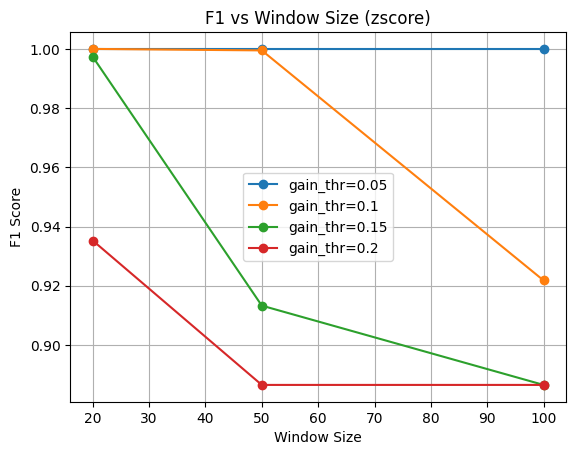

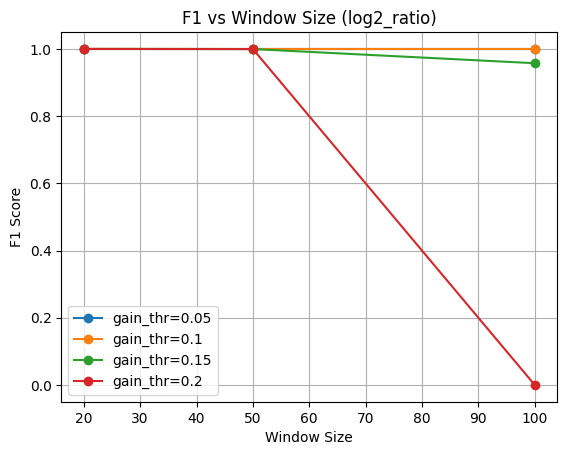

In [7]:
#adata = sc.read_h5ad("PBMC_simulated_cnas_041025.h5ad")


param_grid = [
    {'window': w, 'gain_thr': g, 'loss_thr': -g, 'norm_method': n}
    for w in [20, 50, 100]
    for g in [0.05, 0.1, 0.15, 0.2]
    for n in ['zscore', 'log2_ratio']
]

results = []
for params in param_grid:
    print(f"Evaluating {params}")
    metrics = run_cna_evaluation(adata, params)
    results.append({**params, **metrics})

results_df = pd.DataFrame(results)
print(results_df)


for norm_method in ['zscore', 'log2_ratio']:
    subset = results_df[results_df['norm_method'] == norm_method]
    plt.figure()
    for gthr in subset['gain_thr'].unique():
        subsub = subset[subset['gain_thr'] == gthr]
        plt.plot(subsub['window'], subsub['f1'], marker='o', label=f"gain_thr={gthr}")
    plt.title(f"F1 vs Window Size ({norm_method})")
    plt.xlabel("Window Size")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()



In [8]:
# Explore Impact of Read Depth
downsample_rates = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
downsample_results = []

for rate in downsample_rates:
    print(f"Downsampling to {rate*100:.0f}% reads")
    adata_ds = adata.copy()
    sc.pp.downsample_counts(adata_ds, counts_per_cell=int(adata_ds.X.sum(1).A1.mean() * rate))

    best_params = {'window': 40, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'}
    metrics = run_cna_evaluation(adata_ds, best_params)
    downsample_results.append({'read_depth': rate, **metrics})

downsample_df = pd.DataFrame(downsample_results)
print(downsample_df)


Downsampling to 90% reads
Downsampling to 80% reads
Downsampling to 70% reads
Downsampling to 60% reads
Downsampling to 50% reads
Downsampling to 40% reads
Downsampling to 30% reads
Downsampling to 20% reads
Downsampling to 10% reads
   read_depth  accuracy  precision    recall        f1
0         0.9  1.000000        1.0  1.000000  1.000000
1         0.8  1.000000        1.0  1.000000  1.000000
2         0.7  0.998933        1.0  0.997248  0.998622
3         0.6  0.999418        1.0  0.998499  0.999249
4         0.5  0.999321        1.0  0.998249  0.999124
5         0.4  0.999321        1.0  0.998249  0.999124
6         0.3  0.967892        1.0  0.917188  0.956805
7         0.2  0.970026        1.0  0.922692  0.959792
8         0.1  0.612281        0.0  0.000000  0.000000


c:\Users\clark\anaconda3\envs\OneSC_run\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


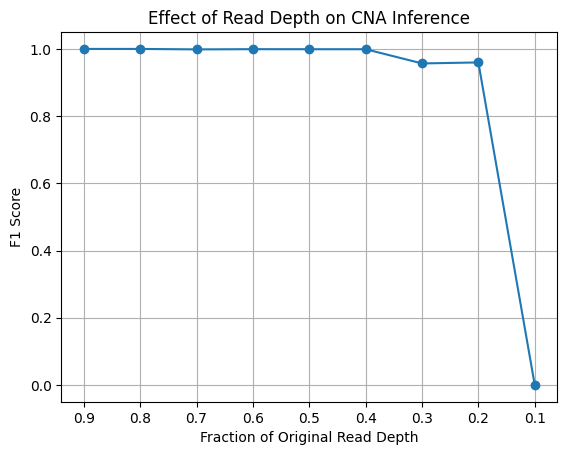

In [9]:

# Plot Read Depth vs F1
plt.figure()
plt.plot(downsample_df['read_depth'], downsample_df['f1'], marker='o')
plt.xlabel("Fraction of Original Read Depth")
plt.ylabel("F1 Score")
plt.title("Effect of Read Depth on CNA Inference")
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

testing

Called CNA segments:
  • ChrHSCHR7_2_CTG1:185290-189896 → gain
                                 simulated_cnvs cna_profile
AAACCCAAGCGCCCAT-1                                         
AAACCCAAGGTTCCGC-1                                         
AAACCCACAGAGTTGG-1  22:19807132-29743868 (CN 0)            
AAACCCACAGGTATGG-1                                         
AAACCCACATAGTCAC-1                                         


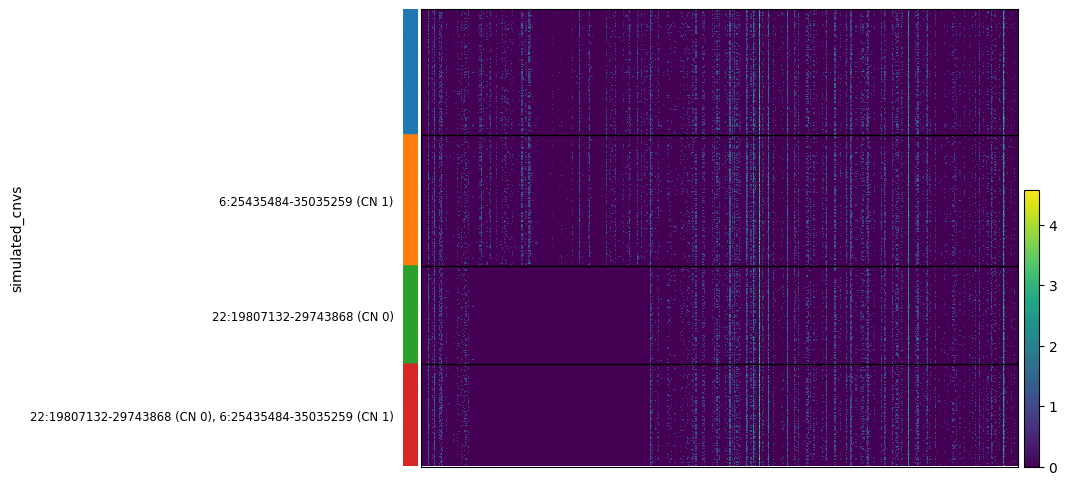

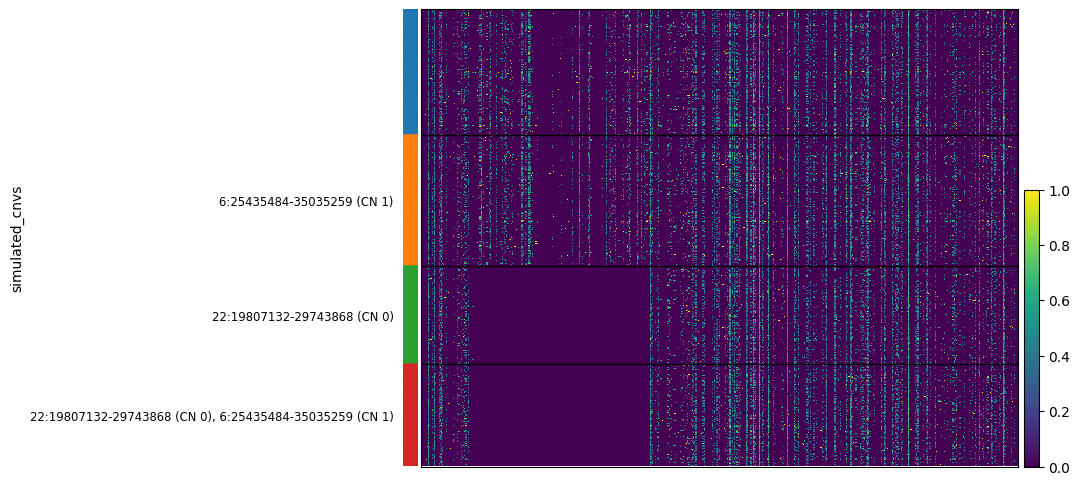

In [9]:
# Visualize CNA calls
print("Called CNA segments:")
for seg in adata.uns['cna_segments']:
    print(f"  • Chr{seg['chrom']}:{seg['start']}-{seg['end']} → {seg['type']}")

print(adata.obs[['simulated_cnvs','cna_profile']].head())

# Example subset for heatmap
adMono = adata[adata.obs['cell_type'] == 'CD14 monocyte'].copy()
adChr22 = adMono[:, adMono.var['chromosome'] == '22'].copy()

sc.pl.heatmap(adChr22, adChr22.var_names, groupby='simulated_cnvs', layer="counts", log=True)
sc.pl.heatmap(adChr22, adChr22.var_names, groupby='simulated_cnvs', layer="counts", log=True, standard_scale='var')



# Compare with infercnvpy

In [12]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
import sys
sys.path.append('../src')  # Adjust this path as necessary
import cna_tool
from cna_tool import infer_cnas_from_scrna
from cna_tool.tl import run_cna_evaluation
import numpy as np


# 1) load and prep
adata = sc.read_h5ad("../data/test_adata.h5ad")
adata = cna_tool.simple_preprocess(adata)
# sc.pp.normalize_total(adata, target_sum=1e6)
# sc.pp.log1p(adata)

In [13]:
# 2) Build a string‐typed reference column
adata.obs["reference"] = [
    "normal" if x=="" else "tumor"
    for x in adata.obs["simulated_cnvs"]
]

adata.obs["reference"] = ["normal" if str(x).strip() == "" else "tumor" for x in adata.obs["simulated_cnvs"]]

adata = adata[:, adata.var.dropna(subset=["chromosome", "start", "end"]).index].copy()
adata.var["chromosome"] = adata.var["chromosome"].astype(str)
adata.var["chromosome"] = adata.var["chromosome"].apply(lambda x: f"chr{x}" if not x.startswith("chr") else x)
adata.var = adata.var.sort_values(["chromosome", "start"])
adata = adata[:, adata.var.index].copy()

In [ ]:

# Define parameter grid
param_grid = [
    {'window': w, 'gain_thr': g, 'loss_thr': -g, 'norm_method': 'log2_ratio'}
    for w in [50, 100, 150, 200]
    for g in [0.05, 0.1, 0.15, 0.2]
]

# Store results
results = []

# Evaluate your method
def evaluate_our_method(adata, params):
    """
    Wrapper that returns only F1 score from our full CNA evaluation.
    """
    metrics = run_cna_evaluation(adata, params)
    return metrics["f1"]


def call_cna_from_infercnv(adata, threshold=0.2):
    """
    Converts infercnvpy's X_cnv sparse matrix into binary CNA presence per cell.

    A cell is labeled '1' if any gene exceeds +/- threshold in smoothed CNV profile.

    Returns:
    - np.array: Binary vector of shape (n_cells,)
    """
    from scipy.sparse import issparse

    X_cnv = adata.obsm["X_cnv"]

    # Convert sparse to dense array if needed
    if issparse(X_cnv):
        X_cnv = X_cnv.toarray()

    # Compute CNA presence
    cna_present = (np.abs(X_cnv) > threshold).any(axis=1)

    return cna_present.astype(int)



In [21]:

# Define parameter grid
param_grid = [
    {'window': w, 'gain_thr': g, 'loss_thr': -g, 'norm_method': 'zscore'}
    for w in [50, 100, 150, 200]
    for g in [0.05, 0.1, 0.15, 0.2]
]

In [ ]:
def evaluate_infercnvpy1(adata, params):
    adata_inf = adata.copy()
    cnv.tl.infercnv(
        adata_inf,
        reference_key="reference",
        reference_cat=["normal"],
        window_size=params['window'],
        step=10,
        dynamic_threshold=params['gain_thr'],
        exclude_chromosomes=["chrX", "chrY"],
        chunksize=500,
        n_jobs=4,
        inplace=True
    )

    y_true = adata_inf.obs["simulated_cnvs"].apply(lambda x: 0 if str(x).strip() == '' else 1)
    y_pred = call_cna_from_infercnv(adata_inf, threshold=params['gain_thr']*5)
    print(y_pred)

    return f1_score(y_true, y_pred)



In [50]:

results2 = []  # Initialize results2 list

# Run both evaluations across the parameter grid and store the results2
for params in param_grid:
    print(f"Evaluating {params}")
    try:
        params['norm_method'] = 'zscore'
        f1_ours_zscore = evaluate_our_method(adata, params)

        params['norm_method'] = 'log2_ratio'
        f1_ourr_log2 = evaluate_our_method(adata, params)

        f1_infercnvpy = evaluate_infercnvpy1(adata, params)

        results2.append({
            'window': params['window'],
            'threshold': params['gain_thr'],
            'f1_ours_zscore': f1_ours_zscore,
            'f1_ours_log2': f1_ourr_log2,
            'f1_infercnvpy': f1_infercnvpy,
        })

    except Exception as e:
        print(f"Skipped params {params} due to error: {e}")

Evaluating {'window': 50, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'}


100%|██████████| 21/21 [00:03<00:00,  5.69it/s]


[1 1 1 ... 1 1 1]
Evaluating {'window': 50, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'log2_ratio'}


100%|██████████| 21/21 [00:03<00:00,  5.78it/s]


[1 1 1 ... 1 1 1]
Evaluating {'window': 50, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'}


100%|██████████| 21/21 [00:03<00:00,  5.82it/s]


[1 0 1 ... 1 0 1]
Evaluating {'window': 50, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'log2_ratio'}


c:\Users\clark\anaconda3\envs\infercnv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 21/21 [00:03<00:00,  5.81it/s]


[1 0 0 ... 0 0 1]
Evaluating {'window': 100, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'}


100%|██████████| 21/21 [00:03<00:00,  5.56it/s]


[1 1 1 ... 1 1 1]
Evaluating {'window': 100, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'log2_ratio'}


100%|██████████| 21/21 [00:03<00:00,  5.67it/s]


[1 1 1 ... 1 1 1]
Evaluating {'window': 100, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'}


100%|██████████| 21/21 [00:03<00:00,  5.77it/s]


[1 0 1 ... 1 0 1]
Evaluating {'window': 100, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'log2_ratio'}


c:\Users\clark\anaconda3\envs\infercnv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 21/21 [00:03<00:00,  5.72it/s]


[1 0 0 ... 0 0 1]
Evaluating {'window': 150, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'}


100%|██████████| 21/21 [00:03<00:00,  5.68it/s]


[1 1 1 ... 1 1 1]
Evaluating {'window': 150, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'log2_ratio'}


100%|██████████| 21/21 [00:03<00:00,  5.62it/s]


[1 1 1 ... 1 1 1]
Evaluating {'window': 150, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'}


100%|██████████| 21/21 [00:03<00:00,  5.82it/s]


[1 0 1 ... 1 0 1]
Evaluating {'window': 150, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'log2_ratio'}


c:\Users\clark\anaconda3\envs\infercnv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 21/21 [00:03<00:00,  5.83it/s]


[1 0 0 ... 0 0 1]
Evaluating {'window': 200, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'}


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


[1 1 1 ... 1 1 1]
Evaluating {'window': 200, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'log2_ratio'}


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


[1 1 1 ... 1 1 1]
Evaluating {'window': 200, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'}


100%|██████████| 21/21 [00:03<00:00,  5.31it/s]


[1 0 1 ... 1 0 1]
Evaluating {'window': 200, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'log2_ratio'}


c:\Users\clark\anaconda3\envs\infercnv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 21/21 [00:03<00:00,  5.54it/s]


[1 0 0 ... 0 0 1]


C:\Users\clark\AppData\Local\Temp\ipykernel_20380\4106822058.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar


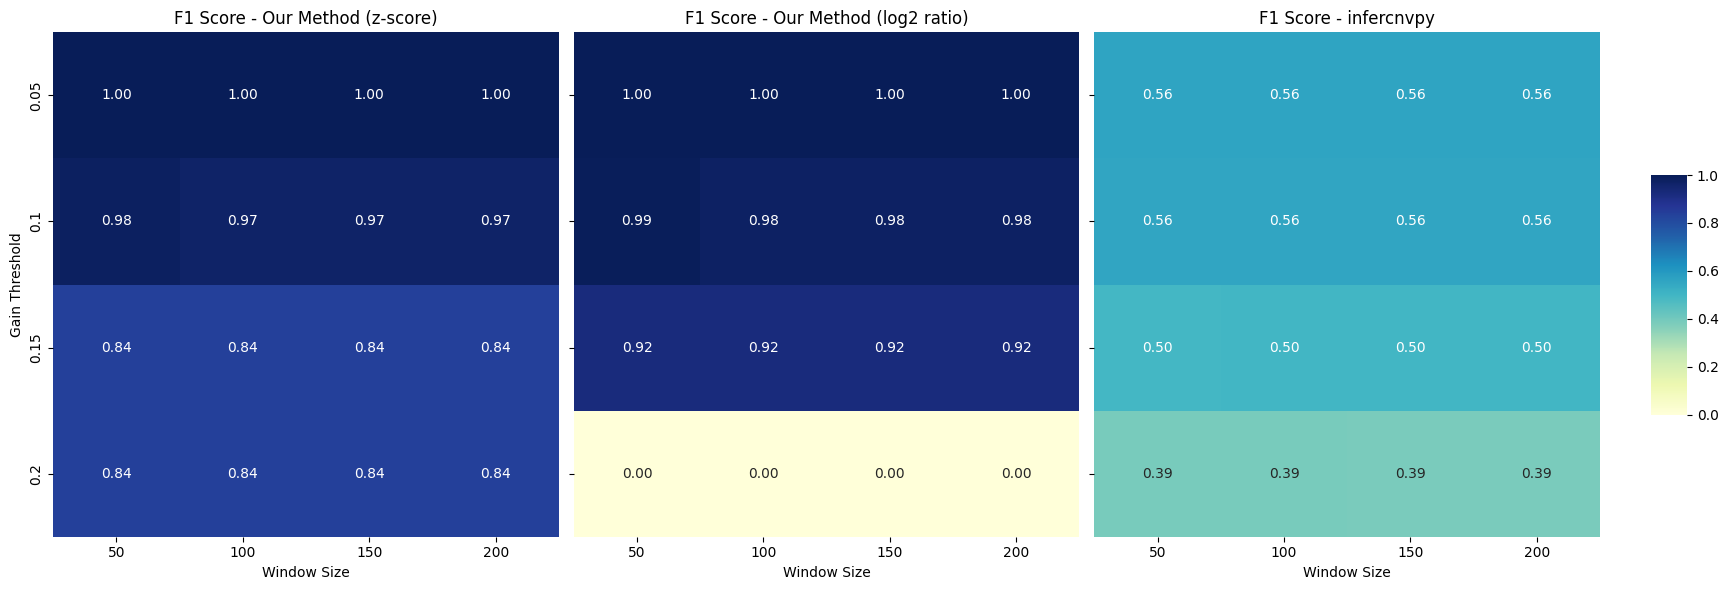

In [51]:

# Convert to DataFrame
df = pd.DataFrame(results2)

# Pivot tables
pivot_zscore = df.pivot(index='threshold', columns='window', values='f1_ours_zscore')
pivot_log2 = df.pivot(index='threshold', columns='window', values='f1_ours_log2')
pivot_infercnvpy = df.pivot(index='threshold', columns='window', values='f1_infercnvpy')

# Determine shared color scale range
vmin = min(pivot_zscore.min().min(), pivot_log2.min().min(), pivot_infercnvpy.min().min())
vmax = max(pivot_zscore.max().max(), pivot_log2.max().max(), pivot_infercnvpy.max().max())

# Create side-by-side plots with shared color bar
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
cbar_ax = fig.add_axes([.92, .3, .02, .4])  # Position for colorbar

sns.heatmap(pivot_zscore, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[0],
            cbar=True, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax)
axes[0].set_title("F1 Score - Our Method (z-score)")
axes[0].set_xlabel("Window Size")
axes[0].set_ylabel("Gain Threshold")

sns.heatmap(pivot_log2, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[1],
            cbar=False, vmin=vmin, vmax=vmax)
axes[1].set_title("F1 Score - Our Method (log2 ratio)")
axes[1].set_xlabel("Window Size")
axes[1].set_ylabel("")

sns.heatmap(pivot_infercnvpy, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[2],
            cbar=False, vmin=vmin, vmax=vmax)
axes[2].set_title("F1 Score - infercnvpy")
axes[2].set_xlabel("Window Size")
axes[2].set_ylabel("")

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar
plt.show()